### Install Required Packages

We would be running Facebook's `Detic` so enable `GPU` under `View Resources > Change runtime type` for faster inference.

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-b34ef61e-a994-e034-ae21-03354afb19b3)


In [2]:
!pip install imagesize # For calculating image size for COCO Dataset, if you have them available no need

#### Detic

We install `Detectron2` as `Detic` requires it for running the models.

In [3]:
# Install Detectron2
!pip install 'git+https://github.com/facebookresearch/detectron2.git@v0.6'

# Clone and install Detic
!git clone https://github.com/facebookresearch/Detic.git --recurse-submodules
%cd Detic
!pip install -r requirements.txt

  Cloning https://github.com/facebookresearch/detectron2.git (to revision v0.6) to /tmp/pip-req-build-vxr72akg
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-vxr72akg
  Running command git checkout -q d1e04565d3bec8719335b88be9e9b961bf3ec464
  Resolved https://github.com/facebookresearch/detectron2.git to commit d1e04565d3bec8719335b88be9e9b961bf3ec464
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.0/131.0 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 14.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for detectron2: filename=

Cloning into 'Detic'...
remote: Enumerating objects: 206, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 206 (delta 57), reused 43 (delta 43), pack-reused 95
Receiving objects: 100% (206/206), 3.58 MiB | 17.14 MiB/s, done.
Resolving deltas: 100% (80/80), done.
Submodule 'third_party/CenterNet2' (https://github.com/xingyizhou/CenterNet2.git) registered for path 'third_party/CenterNet2'
Submodule 'third_party/Deformable-DETR' (https://github.com/fundamentalvision/Deformable-DETR.git) registered for path 'third_party/Deformable-DETR'
Cloning into '/content/Detic/third_party/CenterNet2'...
remote: Enumerating objects: 13925, done.        
remote: Counting objects: 100% (949/949), done.        
remote: Compressing objects: 100% (101/101), done.        
remote: Total 13925 (delta 887), reused 854 (delta 846), pack-reused 12976        
Receiving objects: 100% (13925/13925), 5.08 MiB | 18.65 MiB/s, done.
Resolving deltas: 10

### Load Necessary Libraries

We will load the necessary libraries, which would be required to run Inference with Detic and Configure it.

In [4]:
# General
import shutil
import os
import gc
import sys
import json
import time
import random
from tqdm import tqdm
import datetime
from pathlib import Path
from typing import Iterable, List, NamedTuple

# Plotting and Image Processing
from matplotlib import pyplot as plt
import cv2
import imagesize
from google.colab.patches import cv2_imshow
from PIL import Image

# Math and Data Handling
import numpy as np
import pandas as pd
from numpy import ndarray
from pycocotools.coco import COCO
from torch.utils.data import DataLoader, Dataset

# PyTorch
import torch

# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
import detectron2.data.transforms as T
from detectron2.modeling import build_model
from detectron2.structures import Instances
from detectron2.engine import DefaultPredictor
from detectron2.config import CfgNode, get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.data import MetadataCatalog, DatasetCatalog


# Detic libraries
sys.path.insert(0, 'third_party/CenterNet2/') # -----> Make sure your Detic folder has this folder (clone it if required)
from centernet.config import add_centernet_config
from detic.config import add_detic_config
from detic.modeling.utils import reset_cls_test

### Setup Detic

Configure `Detic` below and download its pretrained weights.

In [43]:
# Obtain Detectron2's default config
cfg = get_cfg()
# Add CenterNet config to our config (Detic uses it for anchorless Object Detection)
add_centernet_config(cfg)
# Add Detic config to our config
add_detic_config(cfg)
# Add config values from file
cfg.merge_from_file("configs/Detic_LbaseI_CLIP_SwinB_896b32_4x_ft4x_max-size.yaml")
# Add link to weights for Detic
cfg.MODEL.WEIGHTS = 'https://dl.fbaipublicfiles.com/detic/Detic_LbaseI_CLIP_SwinB_896b32_4x_ft4x_max-size.pth'

# Filter our low score Regions proposed hence set threshold for this model
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
# cfg.MODEL.ROI_BOX_HEAD.ZEROSHOT_WEIGHT_PATH = 'rand'
# For better visualization purpose. Set to False for all classes.
cfg.MODEL.ROI_HEADS.ONE_CLASS_PER_PROPOSAL = True

# which device to use
cfg.MODEL.DEVICE = 'cuda'

# cfg.MODEL.DEVICE='cpu' # uncomment this to use cpu-only mode.
# predictor = DefaultPredictor(cfg)

The following are the built-in (some from `Detectron2` and some from `Detic`) vocabularies available.

In [6]:
BUILDIN_CLASSIFIER = {
    'lvis': 'datasets/metadata/lvis_v1_clip_a+cname.npy',
    'objects365': 'datasets/metadata/o365_clip_a+cnamefix.npy',
    'openimages': 'datasets/metadata/oid_clip_a+cname.npy',
    'coco': 'datasets/metadata/coco_clip_a+cname.npy',
}

BUILDIN_METADATA_PATH = {
    'lvis': 'lvis_v1_val',
    'objects365': 'objects365_v2_val',
    'openimages': 'oid_val_expanded',
    'coco': 'coco_2017_val',
}

Choose your vocabulary from one of the above.

In [7]:
vocabulary = 'coco' # change to 'lvis', 'objects365', 'openimages', or 'coco'

In [8]:
# Setup the model's vocabulary using build-in datasets
metadata = MetadataCatalog.get(BUILDIN_METADATA_PATH[vocabulary])
classifier = BUILDIN_CLASSIFIER[vocabulary]
object_classes = metadata.thing_classes # object classes
num_classes = len(metadata.thing_classes) # The number of classes in our vocabulary
# reset_cls_test(predictor.model, classifier, num_classes)

In [9]:
pd.DataFrame({'object classes': object_classes})

,object classes
0,person
1,bicycle
2,car
3,motorcycle
4,airplane
...,...
75,vase
76,scissors
77,teddy bear
78,hair drier


In [10]:
# Creating the categories dictionary which is to be included in the COCO Annotation File
categories = list()
for id, obj in enumerate(object_classes):
  categories.append({
      'supercategory': '',
      'id': id + 1,
      'name': obj
  })

### Load Data

Here I download the data. If you already have it skip to entering the `IMAGE DIRECTORY PATH`.

In [11]:
import zipfile
!wget -nc http://images.cocodataset.org/zips/val2017.zip

--2023-07-05 10:37:12--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.236.43, 52.217.162.17, 52.216.220.145, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.236.43|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  13.3MB/s    in 60s     

2023-07-05 10:38:13 (12.9 MB/s) - ‘val2017.zip’ saved [815585330/815585330]



In [12]:
os.mkdir('datasets/coco')

In [13]:
zf = zipfile.ZipFile('val2017.zip')
zf.extractall('datasets/coco')

Enter the Directory Path (`IMAGE_DIRECTORY_PATH`) which contains all the images which needs to be annotated by `Detic`.

In [14]:
IMAGE_DIRECTORY_PATH = 'datasets/coco/val2017' # Enter Directory containing all the images
NAME_OF_DATASET = 'coco_2017_val'

Enter the `info` about the `licenses` of the image dataset you are using below

In [15]:
info = { # Info about the dataset
    "description": NAME_OF_DATASET,
    "url": "https://github.com/RishiDarkDevil/Text-Based-Object-Discovery",
    "version": "1.0",
    "year": 2023,
    "contributor": "Rishi Dey Chowdhury (RishiDarkDevil)",
    "date_created": "2023"
}

licenses = [{ # Licenses associated with the dataset
    'url': 'https://github.com/RishiDarkDevil/Text-Based-Object-Discovery',
    'id': 1,
    'name': 'MIT License'
}]

We prepare the `ImageDataset` consisting of the list of paths to the image files. We will load them when required i.e. when we want to `__getitem__`.

In [16]:
class ImageDataset(Dataset):
  """
  Image Dataset, it loads the images from the paths when an item is fetched
  """
  def __init__(self, imagery: List[Path]):
    self.imagery = imagery

  def __getitem__(self, index) -> ndarray:
    return cv2.imread(self.imagery[index])

  def __len__(self):
    return len(self.imagery)

We need to pass a list consisting of the image paths to the `ImageDataset` and then we are ready to use our nifty little `ImageDataset`.

In [17]:
# Image paths
image_names = os.listdir(IMAGE_DIRECTORY_PATH)
image_paths = [os.path.join(IMAGE_DIRECTORY_PATH, name) for name in image_names]

# Dataset
data = ImageDataset(image_paths)

In [18]:
images = list() # Contains the image details
for image_id, image_name in enumerate(image_names):

  # Calculating image size
  width, height = imagesize.get(image_paths[image_id])

  images.append({ # Contains the image details
      'license': 1,
      'file_name': image_name,
      'height': height,
      'width': width,
      'date_captured': datetime.datetime.now().strftime("%m/%d/%Y, %H:%M:%S"),
      'id': image_id + 1
    })

Let's view some example image from our dataset.

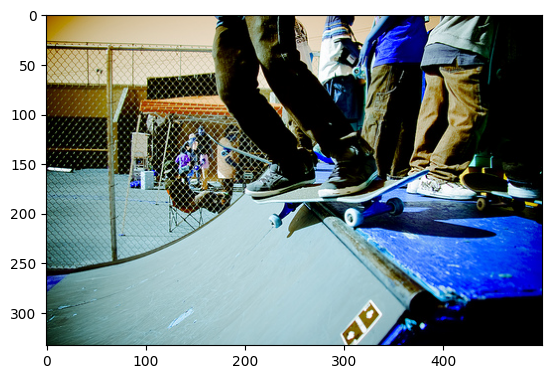

In [19]:
plt.imshow(data[0])

In [20]:
len(data)

5000

### Inference Detic

Set some parameters.

In [47]:
BATCH_SIZE = 2 # Batch Size i.e. the number of images to be processed at once
NUM_WORKERS = 0 # Number of worker for the DataLoader
SAVE_AFTER = 10 # After how many batches to save the results

We will store all the annotations in the following `Detic-Annotation` folder.

In [48]:
# import shutil
# shutil.rmtree('Detic-Annotation')

In [49]:
# The folder that will contain the predicted output
os.mkdir('Detic-Annotation')

annotations = list() # Contains all the predicted annotations
save_idx = 0 # Contains save index

In [50]:
class NpEncoder(json.JSONEncoder): # To help encode the unsupported datatypes to json serializable format
  def default(self, obj):
    if isinstance(obj, np.integer):
        return int(obj)
    if isinstance(obj, np.floating):
        return float(obj)
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    return json.JSONEncoder.default(self, obj)

def save(): # Saving annotations and captions when called -- mainly to avoid code repetition

  # To prevent creating new scope
  global save_idx

  # Serializing json
  json_obj_det = json.dumps({
      'info': info,
      'licenses': licenses,
      'images': images,
      'annotations': annotations,
      'categories': categories
  }, indent=4, cls=NpEncoder)

  # Writing json
  with open(f"Detic-Annotation/object_detect-{save_idx}.json", "w") as outfile:
    outfile.write(json_obj_det)

  save_idx += 1

  # Clearing up the annotation list to accomodate for more annotation as it comes
  annotations.clear()

  print('Saved Annotations')

The following function helps free up the unused GPU RAM from time to time, during inference. Greatly helps in reducing `OOMError`.

In [51]:
# Frees up GPU to help reduce memory leak
def optimize_gpu():
  # Reset Already occupied Memory and Cache
  torch.cuda.reset_max_memory_allocated()
  torch.cuda.reset_max_memory_cached()
  torch.cuda.empty_cache()

  # Garbage Collection
  gc.collect()

`Detic` generates masks for instance segmentation instead of polygons. So the following function helps to convert mask to polygon. As we decided to store in that format the segmentation in the COCO Annotation File.

In [52]:
def mask_to_polygons(mask):
  # cv2.RETR_CCOMP flag retrieves all the contours and arranges them to a 2-level
  # hierarchy. External contours (boundary) of the object are placed in hierarchy-1.
  # Internal contours (holes) are placed in hierarchy-2.
  # cv2.CHAIN_APPROX_NONE flag gets vertices of polygons from contours.
  mask = np.ascontiguousarray(mask)  # some versions of cv2 does not support incontiguous arr
  res = cv2.findContours(mask.astype("uint8"), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  hierarchy = res[-1]
  if hierarchy is None:  # empty mask
      return [], False
  # has_holes = (hierarchy.reshape(-1, 4)[:, 3] >= 0).sum() > 0
  res = res[-2]
  # Total area for all the polygon's area added up
  tot_area = np.sum([cv2.contourArea(cnt) for cnt in res])
  res = [x.flatten() for x in res]
  # These coordinates from OpenCV are integers in range [0, W-1 or H-1].
  # We add 0.5 to turn them into real-value coordinate space. A better solution
  # would be to first +0.5 and then dilate the returned polygon by 0.5.
  res = [x + 0.5 for x in res if len(x) >= 6]
  return res, tot_area

The following can be treated as a general class to allow batch inference on images using any `Detectron2` model (in our case `Detic`).

In [53]:
class BatchPredictor:
  """
  Batch Prediction from Detectron2's model, in our case Detic
  """

  def __init__(self, cfg, classes, batch_size, workers):

    print('*** SETTING UP THE MODEL ***')

    self.cfg = cfg.clone()  # cfg can be modified by model
    self.classes = classes # object classes
    self.batch_size = batch_size # batch size
    self.workers = workers # number of workers
    self.model = build_model(self.cfg) # builds the model
    self.model.eval()
    self.image_id = 1 # Image ID
    self.annotation_id = 1 # Annotation ID

    checkpointer = DetectionCheckpointer(self.model)
    checkpointer.load(cfg.MODEL.WEIGHTS)

    print('*** DONE ***')

  def __collate(self, batch):
    """
    Creates the input which the model expects and
    Converts into PyTorch acceptable format
    """
    data = []
    for image in batch:
      height, width = image.shape[:2]
      image = image.astype("float32").transpose(2, 0, 1)
      image = torch.as_tensor(image)
      data.append({"image": image, "height": height, "width": width})
    return data

  def __call__(self, imagery):
    """[summary]
    The acutal inference code which handles calling the model
    """

    # Creating the Image Dataset
    dataset = ImageDataset(imagery)

    # Setting up the DataLoader
    loader = DataLoader(
      dataset,
      self.batch_size,
      shuffle=False,
      num_workers=self.workers,
      collate_fn=self.__collate,
      pin_memory=True
    )

    print('*** INFERENCE ***')
    print('Number of Images to be processed:', len(dataset))
    print()

    k = 0 # Batch Index

    with torch.no_grad():

      for batch in tqdm(loader):

        k += 1 # Update batch index

        optimize_gpu()

        # Run the model on the batch
        results: List[Instances] = self.model(batch)

        # Add the results
        for result in results:
          for ann in self.__map_predictions(result['instances']):
            annotations.append(ann)

        # Save prediction results
        if k % SAVE_AFTER == 0:
          save()

        # Delete unused variables
        del results

        optimize_gpu()

    # Save prediction results
    if k % SAVE_AFTER != 0:
      save()

    print()
    print('*** DONE ***')


  def __map_predictions(self, instances):
    """
    Converts the predictions into COCO format
    """
    instance_predictions = zip(
      instances.get('pred_boxes'),
      instances.get('pred_masks').cpu().numpy(),
      instances.get('scores').cpu().numpy(),
      instances.get('pred_classes').cpu().numpy()
    )

    predictions = []

    # Converting the Prediction into COCO format
    for box, mask, score, class_index in instance_predictions: # !!!!!!!!! HANDLE MASK
      # The COCO format requirement
      x1 = box[0].item()
      y1 = box[1].item()
      x2 = box[2].item()
      y2 = box[3].item()
      width = x2 - x1
      height = y2 - y1

      segments, area = mask_to_polygons(mask)

      ann_det = { # Annotation details
        'segmentation': segments,
        'area': area,
        'iscrowd': 0,
        'image_id': self.image_id,
        'bbox': [x1, y1, width, height],
        'category_id': class_index+1,
        'id': self.annotation_id,
      }

      self.annotation_id += 1

      predictions.append(ann_det)

    self.image_id += 1
    # Delete unused variables
    del instance_predictions

    return predictions

Setting up the predictor for running.

In [54]:
predictor = BatchPredictor(cfg=cfg, classes=object_classes, batch_size=BATCH_SIZE, workers=NUM_WORKERS)

*** SETTING UP THE MODEL ***
*** DONE ***


Resetting the final layer weights to the vocabulary, as the original model is trained on `ImageNet-21k` and generateds the prediction `class_ids` in that range.

In [55]:
reset_cls_test(predictor.model, classifier, num_classes)

Resetting zs_weight datasets/metadata/coco_clip_a+cname.npy


Below we run the model and generate predictions.

In [ ]:
predictor(image_paths[:2])

In [ ]:
# Free Up Any Occupied Memory
optimize_gpu()

In [ ]:
# # Uncomment to remove the Detic-Annotation Folder along with it's contents
# import shutil
# shutil.rmtree('Detic-Annotation')

Now, I will be generating multiple annotation files. So, I merge them into single annotation file.

In [ ]:
print('Starting Annotation Files Merge...')
# Annotation File Names present in the annotations directory
ann_file_names = os.listdir('Detic-Annotation')
print('Number of Annotation Files found:', len(ann_file_names))
print('Annotation Files found:', ' '.join(ann_file_names))
ann_files = list() # Contains the list of loaded annotation json files
for ann_file_name in tqdm(ann_file_names): # Loads the annotation json files and appens to ann_files
  with open(os.path.join('Detic-Annotation', ann_file_name)) as json_file:
    ann_file = json.load(json_file)
    ann_files.append(ann_file)
# Creating the single annotation file
annotation_file = {
    'info': ann_files[0]['info'],
    'licenses': ann_files[0]['licenses'],
    'images': [image for ann_file in ann_files for image in ann_file['images']],
    'annotations': [ann for ann_file in ann_files for ann in ann_file['annotations']],
    'categories': [cat for ann_file in ann_files for cat in ann_file['categories']]
}
# Serializing json
ann_json_file = json.dumps(annotation_file, indent=4)
# Writing json
with open(f"Detic-Annotation/annotations.json", "w") as outfile:
  outfile.write(ann_json_file)
print()
print('Saved Annotation file... annotations.json')
# UNCOMMENT IF YOU WISH TO REMOVE ALL THE ANNOTATION FILES EXCEPT ONE BIG ANNOTATION FILE
# print('Removing the annotation files other than annotations.json')
# for ann_file_name in ann_file_names:
#   os.remove(os.path.join('Data-Generated/annotations', ann_file_name))
print('A successful merge!')

### Visualizing Predictions

Set the `annotation_path` below.

In [153]:
annotation_path = r'Detic-Annotation/annotations.json' # Annotation File Path

In [154]:
coco_annotation = COCO(annotation_file=annotation_path) # Creating COCO wrapper for our annotation

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


Below we visualize our `Detic` annotated dataset. We now can exploit the benefit of using COCO dataset format, i.e. COCO utility functions for visualizing the results.

In [155]:
def visualize_annotation(image_id, figsize = (20,10)):
  # Load Image Details corresponding to the image_id
  img_info = coco_annotation.loadImgs([image_id])[0]
  img_file_name = img_info['file_name']
  # Load Annotation Details corresponding to the image_id
  ann_ids = coco_annotation.getAnnIds(imgIds=[image_id], iscrowd=None)
  anns = coco_annotation.loadAnns(ann_ids)
  # Load Image corresponding to the image_id
  im = Image.open(os.path.join(IMAGE_DIRECTORY_PATH, img_file_name))
  # Plot and visualize results
  fig, ax = plt.subplots(1, 2, figsize=figsize)
  ax[0].axis('off')
  ax[1].axis('off')
  ax[0].imshow(np.asarray(im))
  ax[1].imshow(np.asarray(im))
  coco_annotation.showAnns(anns, draw_bbox=True)
  ann_names = [coco_annotation.loadCats(ann['category_id'])[0]['name'] for ann in anns]
  for i, ann in enumerate(anns):
    ax[1].text(anns[i]['bbox'][0], anns[i]['bbox'][1], ann_names[i], style='italic',
            bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 5})
  plt.show()

Let's visualize random `NUM_IMAGES_VISUALISATIONS` images and their annotations.

In [156]:
NUM_IMAGES_VISUALISATIONS = 2 # Number of images to visualize

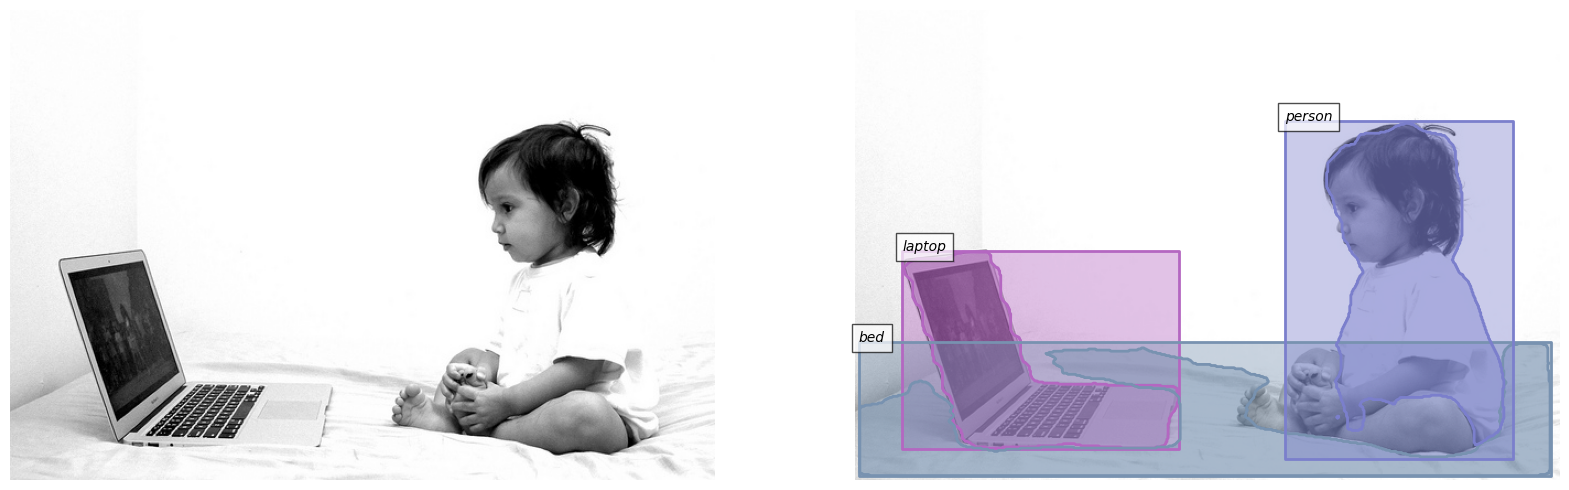

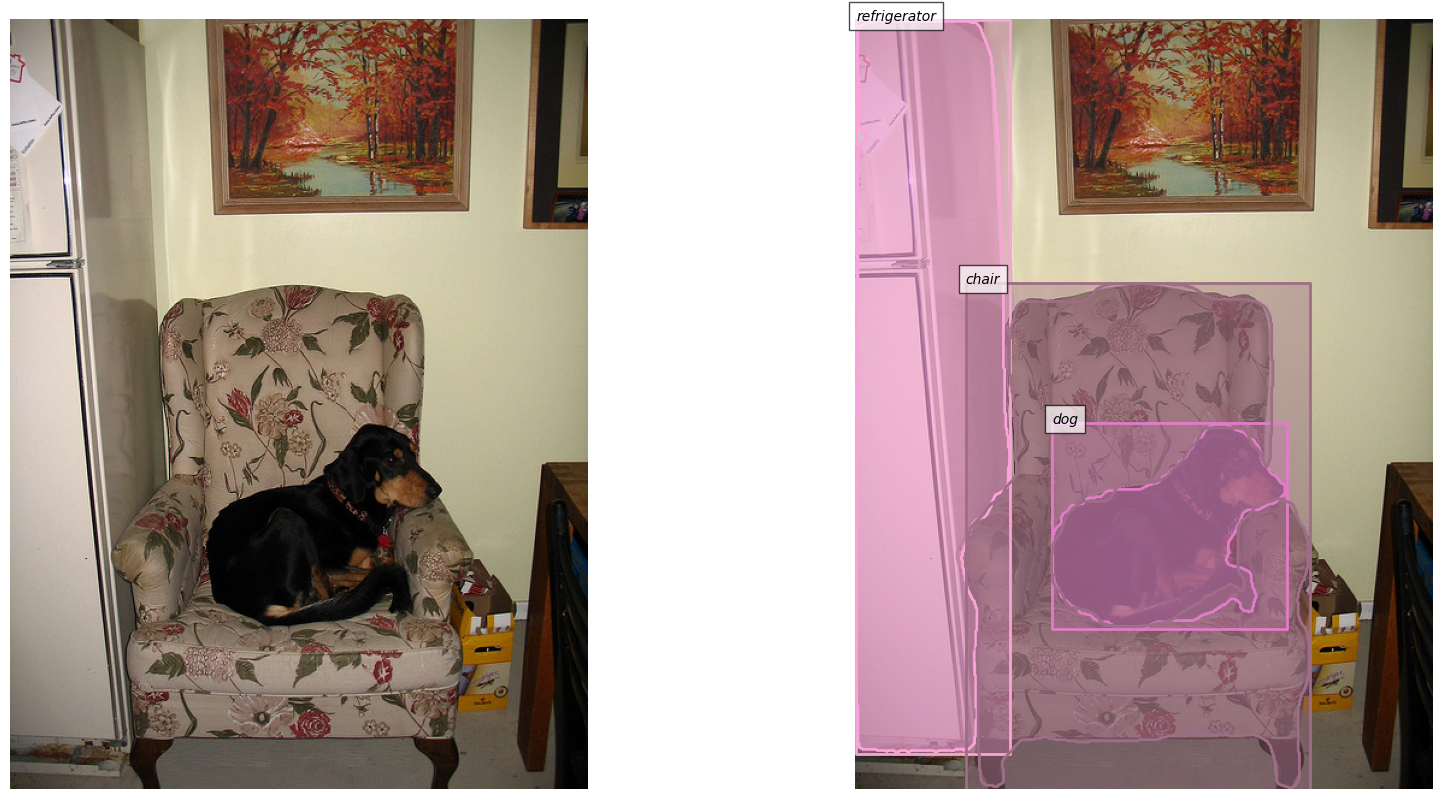

In [157]:
random_image_ids = random.sample(list(range(1,3)), NUM_IMAGES_VISUALISATIONS)
for i in random_image_ids:
  try:
    visualize_annotation(i)
  except Exception as e:
    print(f'Skipping {i}th visualization...')

### Evaluation

#### Load Evaluation Annotation Dataset

Run the code upto `Inference Detic` then run from below for evaluation.

Load Evaluation Annotations.

In [ ]:
# COCO original validation dataset
!wget -nc http://images.cocodataset.org/annotations/annotations_trainval2017.zip

In [22]:
# place the coco original validation dataset in it's correct place
zf = zipfile.ZipFile('annotations_trainval2017.zip')
zf.extractall('datasets/coco')

# place the class agnostic COCO dataset in correct place
if not os.path.exists('datasets/coco/annotations'):
  os.mkdir('datasets/coco/annotations')

shutil.move('coco_cls_agnostic_instances_val2017.json', 'datasets/coco/annotations/coco_cls_agnostic_instances_val2017.json')

'datasets/coco/annotations/coco_cls_agnostic_instances_val2017.json'

Create Evaluator for COCO dataset and run evaluation.

In [56]:
from train_net import do_test

In [57]:
# setting evaluation dataset
cfg.DATASETS.TEST = ('coco_2017_val',)

In [58]:
cfg.SOLVER.IMS_PER_BATCH = 64

In [59]:
# build model
model = build_model(cfg)
# limit the predictions to COCO objects
reset_cls_test(model, classifier, num_classes)
# Checkpoint
DetectionCheckpointer(model, save_dir=cfg.OUTPUT_DIR).resume_or_load(cfg.MODEL.WEIGHTS, resume=False)

Resetting zs_weight datasets/metadata/coco_clip_a+cname.npy


  roi_heads.box_predictor.0.cls_score.zs_weight
  roi_heads.box_predictor.1.cls_score.zs_weight
  roi_heads.box_predictor.2.cls_score.zs_weight


{}

In [60]:
# evaluate
res = do_test(cfg, model)

[07/05 10:56:47 d2.data.datasets.coco]: Loaded 5000 images in COCO format from datasets/coco/annotations/instances_val2017.json
[07/05 10:56:47 d2.data.build]: Distribution of instances among all 80 categories:
|   category    | #instances   |   category   | #instances   |   category    | #instances   |
|:-------------:|:-------------|:------------:|:-------------|:-------------:|:-------------|
|    person     | 10777        |   bicycle    | 314          |      car      | 1918         |
|  motorcycle   | 367          |   airplane   | 143          |      bus      | 283          |
|     train     | 190          |    truck     | 414          |     boat      | 424          |
| traffic light | 634          | fire hydrant | 101          |   stop sign   | 75           |
| parking meter | 60           |    bench     | 411          |     bird      | 427          |
|      cat      | 202          |     dog      | 218          |     horse     | 272          |
|     sheep     | 354          |     

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[07/05 10:56:49 d2.evaluation.evaluator]: Start inference on 5000 batches
[07/05 10:56:58 d2.evaluation.evaluator]: Inference done 1/5000. Dataloading: 1.0243 s/iter. Inference: 8.5891 s/iter. Eval: 0.0631 s/iter. Total: 9.6795 s/iter. ETA=13:26:27
[07/05 10:57:03 d2.evaluation.evaluator]: Inference done 17/5000. Dataloading: 0.0016 s/iter. Inference: 0.2757 s/iter. Eval: 0.0388 s/iter. Total: 0.3162 s/iter. ETA=0:26:15
[07/05 10:57:08 d2.evaluation.evaluator]: Inference done 33/5000. Dataloading: 0.0020 s/iter. Inference: 0.2788 s/iter. Eval: 0.0349 s/iter. Total: 0.3159 s/iter. ETA=0:26:08
[07/05 10:57:14 d2.evaluation.evaluator]: Inference done 50/5000. Dataloading: 0.0020 s/iter. Inference: 0.2775 s/iter. Eval: 0.0340 s/iter. Total: 0.3136 s/iter. ETA=0:25:52
[07/05 10:57:19 d2.evaluation.evaluator]: Inference done 66/5000. Dataloading: 0.0020 s/iter. Inference: 0.2818 s/iter. Eval: 0.0328 s/iter. Total: 0.3167 s/iter. ETA=0:26:02
[07/05 10:57:24 d2.evaluation.evaluator]: Inference

In [61]:
res

OrderedDict([('bbox',
              {'AP': 43.50524590884796,
               'AP50': 60.85467317138774,
               'AP75': 47.199622627199496,
               'APs': 29.155257946081825,
               'APm': 47.443148619904655,
               'APl': 58.25128291848287,
               'AP-person': 21.116045751157923,
               'AP-bicycle': 37.44049762908794,
               'AP-car': 34.32032190667938,
               'AP-motorcycle': 48.16776332100639,
               'AP-airplane': 72.8169655392337,
               'AP-bus': 62.60542519447818,
               'AP-train': 41.41509835892416,
               'AP-truck': 36.76359491389184,
               'AP-boat': 33.81508409900113,
               'AP-traffic light': 29.363664018811797,
               'AP-fire hydrant': 70.91484959283369,
               'AP-stop sign': 71.96146710924322,
               'AP-parking meter': 34.68152632868336,
               'AP-bench': 31.493066102058144,
               'AP-bird': 43.337331111624,
      